In [1]:
import nbsetup
import numpy as np
import seaborn as sns
import pandas as pd
import ergodicpy as ep
import matplotlib.pyplot as plt

# Code for plotting the results

Actual results below.

In [2]:
def plot(data, ax):
    # plot lines    
    g = sns.lineplot(data=pd.DataFrame(data).melt(id_vars=['observations']),
                     x='observations', y='value', hue='variable', palette='icefire', ax=ax)

    # settings reasonable height limits to give scale
    lims = ax.get_ylim()
    lower = min(lims[0], -0.01)
    upper = lims[1] if lims[1] > 1.0 else 1.0
    ax.set(ylim=(lower, upper))
    
    # adding a red zone where it's considered to be ignored
    bound = 0.1
    red_lower = lims[0] if lims[0] > -bound else -bound
    red_lower = 0.0 if red_lower > 0.0 else red_lower
    ax.axhspan(red_lower, bound, color='red', alpha=0.05)
    

def analyse(y_func, x_func=None, noise=None, obs_range=range(50,5000,50)):
    data, ecs = [], []
    
    # generate data
    for o in obs_range:
        # default x
        x = np.random.random(o) if x_func is None else x_func(o)
        
        # generate y incl noise
        y = y_func(x, o)
        if noise is not None:
            y = y + np.random.normal(0, noise, len(y))
        
        # generate metrics
        ec = ep.ErgodicCorrelation(x, y)
        mt = ec.correlations
        mt['observations'] = o
        data.append(mt)
        ecs.append(ec)
    
    # plots
    fig, axes = plt.subplots(1, 3, sharex=False, sharey=False, figsize=(15,5))
    
    # plot scatters
    f = sns.scatterplot(x=ecs[0].x, y=ecs[0].y, ax=axes[0])
    f.set_title("%s observations" % obs_range[0])
    l = sns.scatterplot(x=ecs[-1].x, y=ecs[-1].y, ax=axes[2])
    l.set_title("%s observations" % obs_range[-1])
    
    # plot measures
    plot(data, axes[1])
    
def singular(x, y):
    ec = ep.ErgodicCorrelation(x, y)
    
    # plot the data raw
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False, figsize=(15,5))
    sns.scatterplot(x=x, y=y, ax=axes[0])
    
    # plot the lines in the same format
    first = ec.correlations
    first['observations'] = 0
    second = ec.metrics()
    second['observations'] = 1
    df = pd.DataFrame([first, second])
    plot(df, axes[1])

# No correlations

In all cases when there is no correlation the metrics all tend to 0 and are certainly within the 0.1 bound.

Where we can see that when there are very few observations all metrics become volatile.

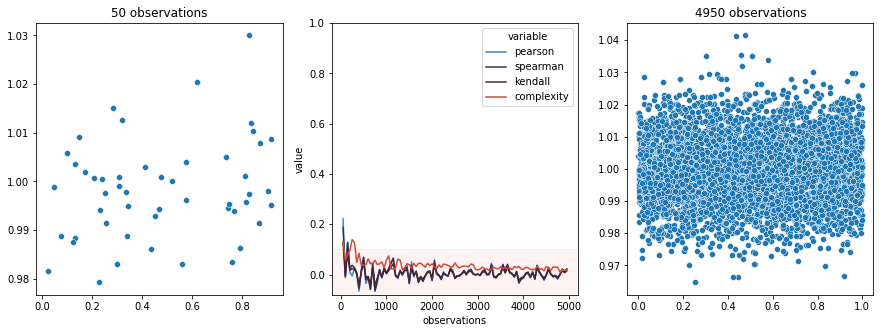

In [3]:
analyse(lambda x, o: np.ones(o), noise=0.01)

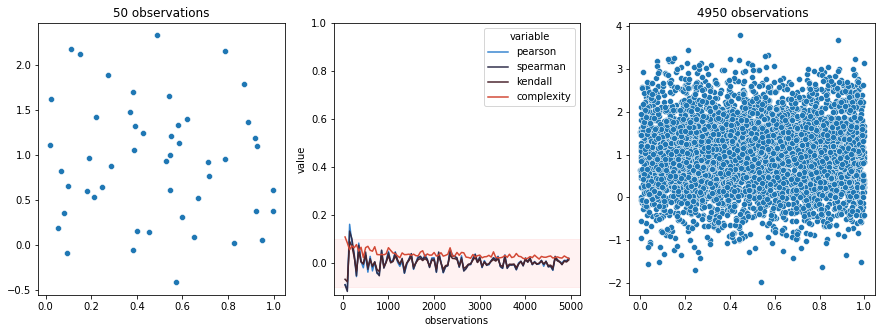

In [4]:
analyse(lambda x, o: np.ones(o), noise=0.8)

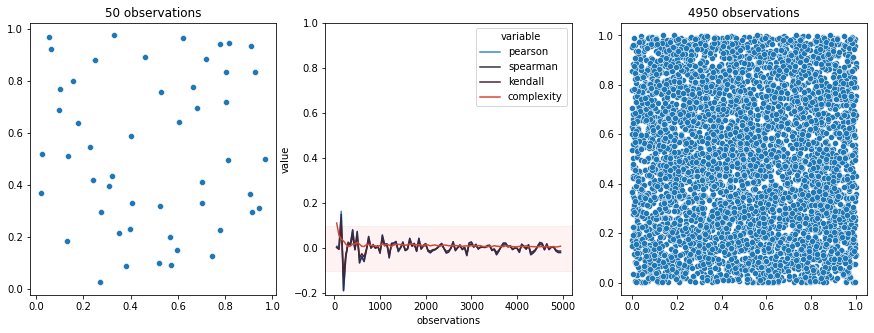

In [5]:
analyse(lambda x, o: np.random.random(o))

# A simple linear correlation

Now we start to see the metrics all shoot up high.

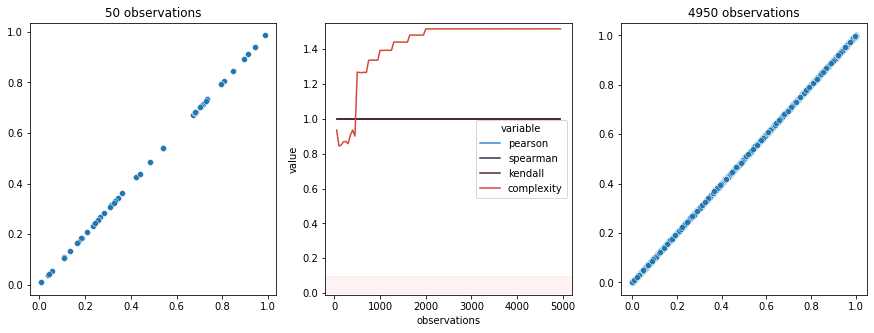

In [6]:
analyse(lambda x,o: x)

# Noise

However, as we introduce noise into the system the PearsonR and SpearmanR metrics perform better.

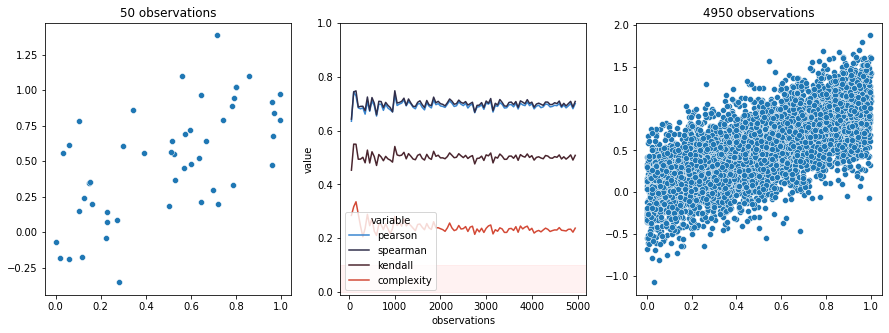

In [7]:
analyse(lambda x,o: x, noise=0.3)

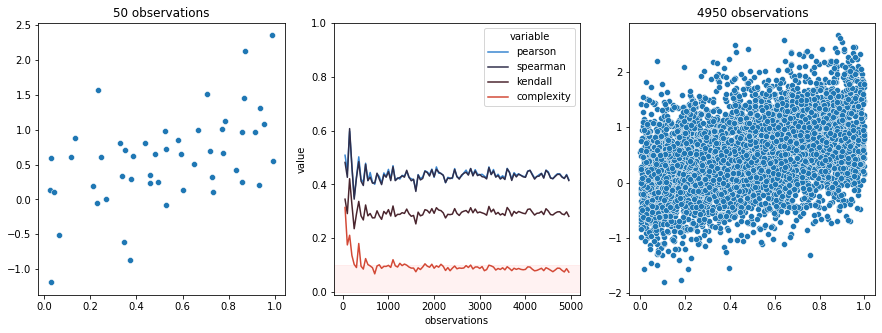

In [8]:
analyse((lambda x,o: x), noise=0.6)

# Reverse

When the correlation is negative complexity picks this up, but does not reflect that the relationship is reversed. This is a feature which is utilised in it's power later.

Here the complexity metric does not give you an accurate measure of the correlation. Instead it's a compliment to encourage you to review the data in more detail and used as a compliment to PearsonR etc.

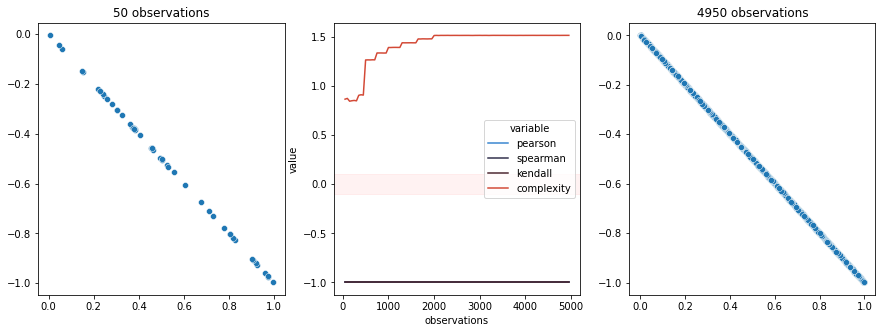

In [9]:
analyse(lambda x, o: -x)

# More exotic shapes

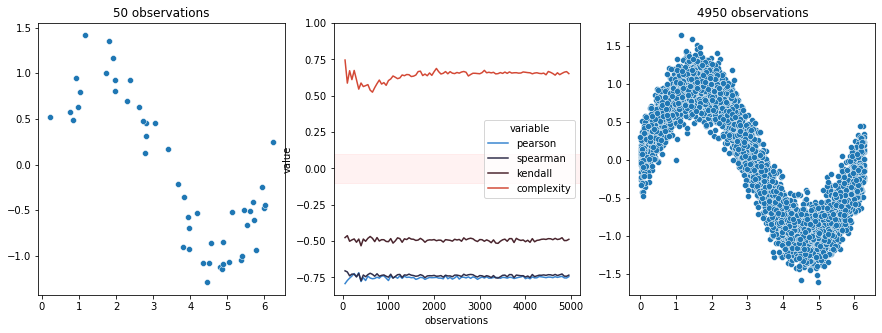

In [10]:
analyse(lambda x,o: np.sin(x), lambda o: np.random.random(o)*np.pi*2, noise=0.2)

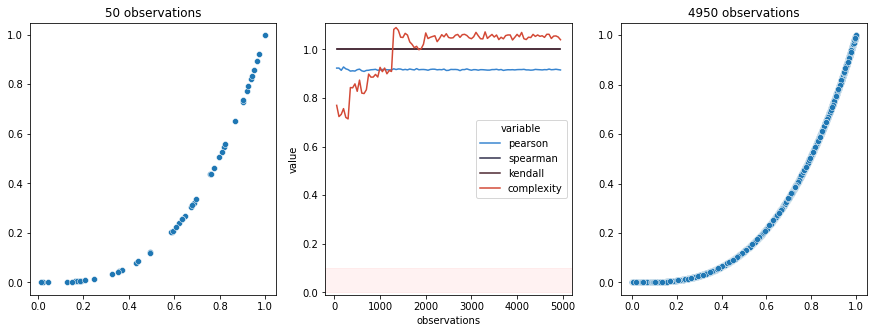

In [11]:
analyse(lambda x,o: x**3)

# Where ergodic complexity is uniquely placed

In the following examples we see the ergodic complexity measure finding an interesting relationship between the data where the other metrics fail.

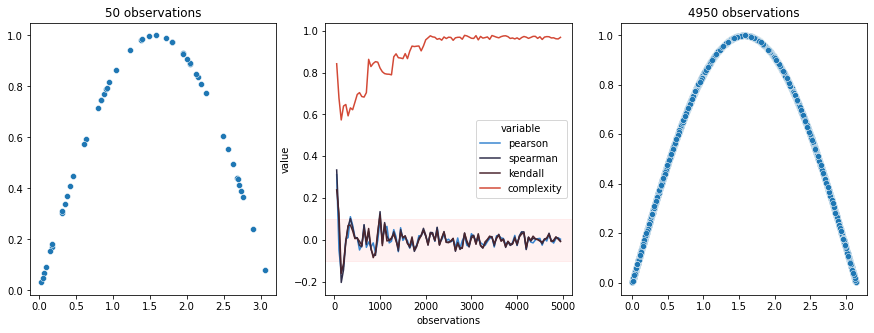

In [12]:
analyse(lambda x,o: np.sin(x), lambda o: np.random.random(o)*np.pi)

It's worth noting the level of noise impacts the absolute level of the ergodic complexity at the same rate irrelavent of relationship or shape of data (e.g. linear as above or sin as below).

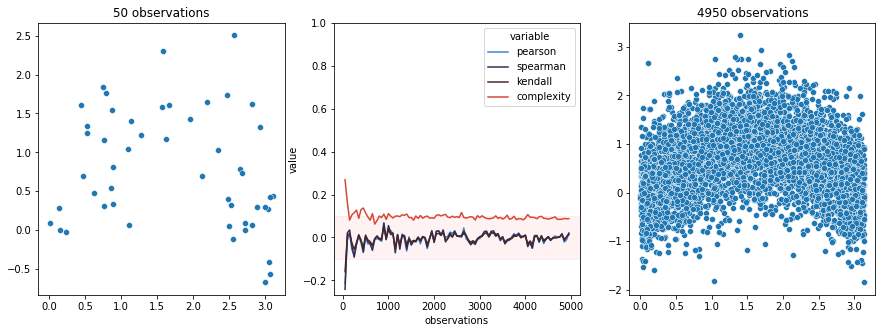

In [13]:
analyse(lambda x,o: np.sin(x), lambda o: np.random.random(o)*np.pi, noise=0.6)

# Specificly shaped models

In [14]:
try:
    funky = pd.read_csv("https://raw.githubusercontent.com/perlatex/R_for_Data_Science/master/demo_data/datasaurus.csv")
except:
    funky = pd.read_csv("../datasets/datasaurus.csv")

Baselining with 142 (the rough number of observations in each shape in the dataset) random observations. Shows that ergodic complexity does better at saying there's no relationship.

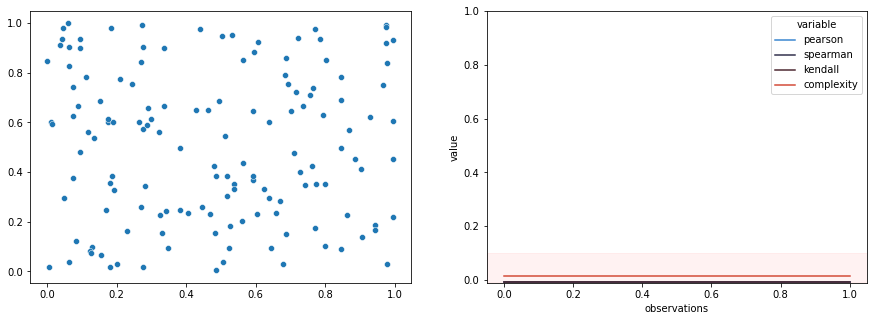

In [32]:
singular(np.random.random(142), np.random.random(142))

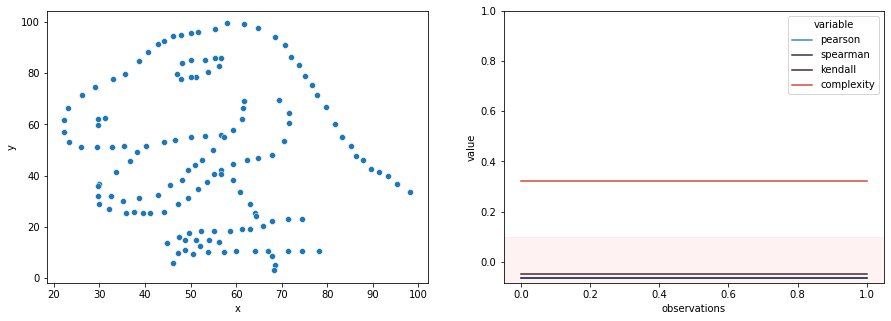

In [16]:
df = funky.loc[funky.dataset == 'dino']
singular(df['x'], df['y'])

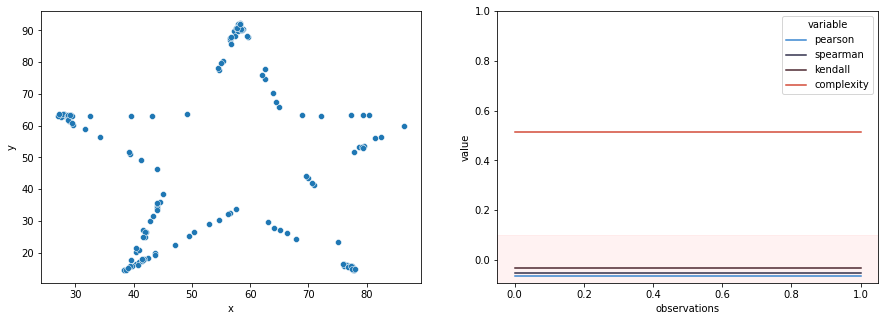

In [17]:
df = funky.loc[funky.dataset == 'star'].reset_index()
singular(df['x'], df['y'])

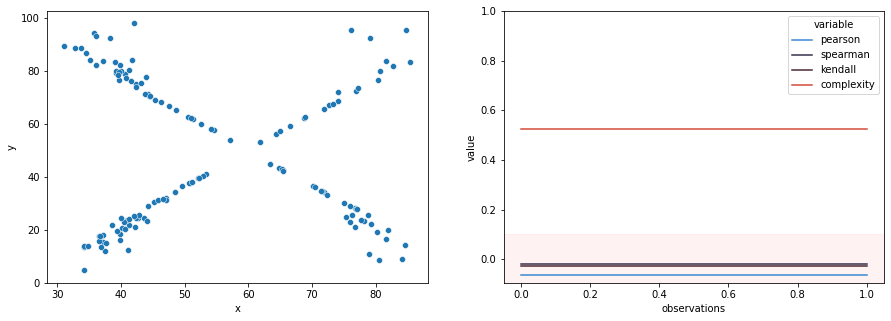

In [18]:
df = funky.loc[funky.dataset == 'x_shape'].reset_index()
singular(df['x'], df['y'])

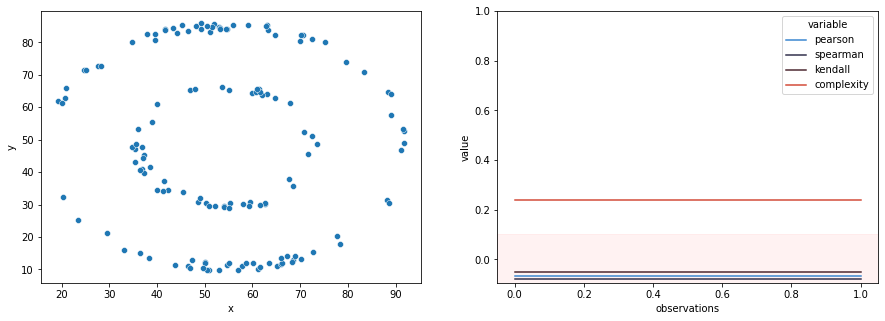

In [19]:
df = funky.loc[funky.dataset == 'bullseye'].reset_index()
singular(df['x'], df['y'])

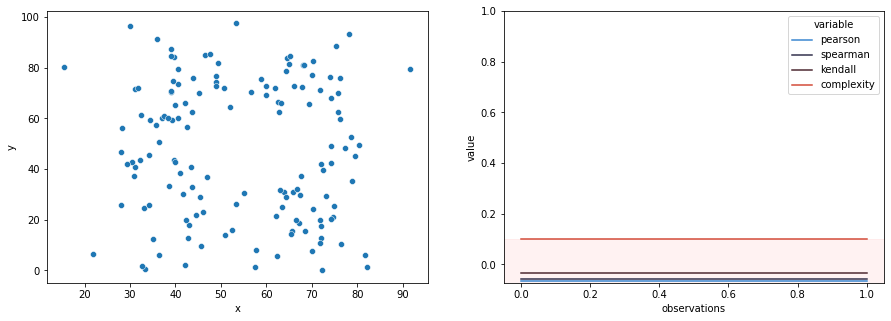

In [20]:
df = funky.loc[funky.dataset == 'away'].reset_index()
singular(df['x'], df['y'])

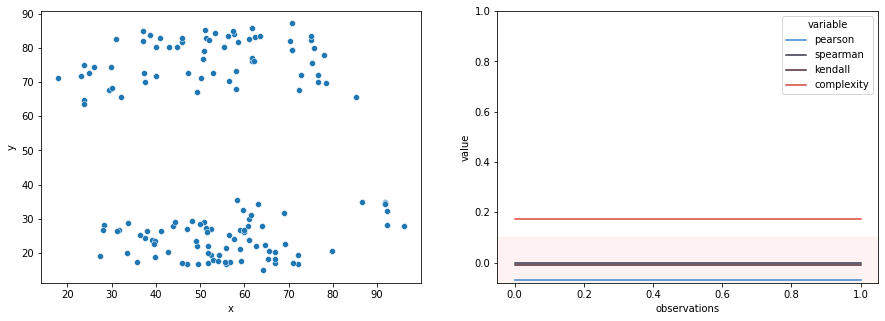

In [21]:
df = funky.loc[funky.dataset == 'high_lines'].reset_index()
singular(df['x'], df['y'])

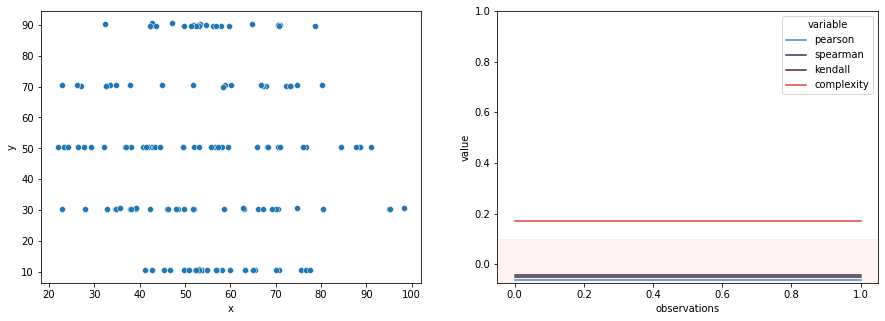

In [22]:
df = funky.loc[funky.dataset == 'h_lines'].reset_index()
singular(df['x'], df['y'])

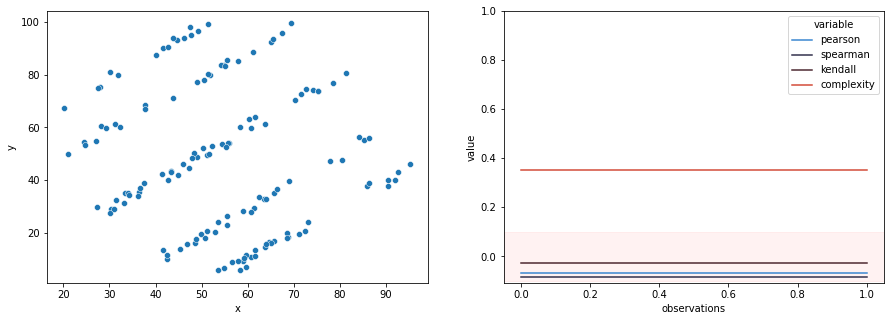

In [23]:
df = funky.loc[funky.dataset == 'slant_up'].reset_index()
singular(df['x'], df['y'])